# Machine Learning Assignment 2
## Semester 01, 2020
---

### `Andrew Ellis`

## Project 1: Classify Images of Road Traffic Signs

### Project Outline:
>Build an end-to-end mcahine learning system that has the ability to predict European road traffic signs. The objective of the system is to perform *two tasks.* **Classify images** according to `sign-shape` and **classify images** according to `sign-type` (such as speed, stop, warning etc.)

### Project Requirements
- Investigate at least one supervised machine learning algorithms for each of the **two categories (Tasks)**. That is, you must build at least one model capable of classified the shape of the sign, and at least one model capable of classifying the type of the sign.
- Investigate different types of algorithms.
- You must fully train your own algorithms. You may not use pre-trained systems.
- **DO NOT** augment this data set with any additional data.
- A final report must conduct an *analysis and comparison* between `classifying the two categories`.

### Independent Evaluation
- There should be an independent evaluation consisting of personally collected classifying images of traffic signs (digital photographs, internet resources etc.) These images must be processed so they may be used with the trained algorithms.
- Discuss challenges faced in combining this independent data and created models.

<a id='top'></a>
# Table of Contents

### [Project Goal](#goal)

### [Data Retrieval](#data_ret)

### [Data Preparation](#data_prep)
- [Assignment of labels](#data_prep_st1)

### [Data Exploration](#data_exp)
- [Overview](#data_exp_ovr)

### [Splitting into Training/Validation Sets](#data_split)

### [Data Modeling](#data_model)
- [Convolutional Neural Network: *Traffic Sign Shapes*](#data_model_cnn)
    - [Simple Image Model](#data_model_cnn_simple)
    - [Simple Image Generator](#data_model_simple_generator)
    - [Augmented Image Generator](#data_model_cnn_aug)
- [Shape Predictions with Augmented Image CNN Model](#data_model_aug_pred)


- [Convolutional Neural Network: *Traffic Sign Types*](#data_model_cnn_sign_type)
- [Type Predictions with Augmented Image CNN Model](#data_model_aug_pred_sign_type)

    
### [Project Review](#proj_rev)

### [References](#ref)

<a id="goal"></a>
## Project Goal
The goal of this project is to create a image classification model that can input personally collected images of road `traffic signs`  and output both the signs `type` and `shape`. *Type* refers to the conditional logic **printed** on the sign itself.

A secondary goal of the project is to evaluate  the chosen *algorithm(s)* performance, approaches and insight into process.

In [1]:
# Project packages used
import warnings
warnings.filterwarnings('ignore')

import os
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display 
from PIL import Image

<a id="data_ret"></a>
# Data Retrieval

The projects Traffic Sign data set has been supplied by the RMIT Univeristy 2020 Machine Learning & Computational Machine Learning course **`COSC2673`** under course coordinator Dr Ruwan Tennakoon.

This data set is an adjusted and prepared subset of the original `BelgiumTSC - The Belgium Traffic Sign Classification Benchmark set`.

The images are greyscale and are a consistent 28x28 dimension.

*Please note that traffic sign shapes contain sign types, such that `[ Sign Shape [ Sign Type ] ]`*

The `traffic signs` **shapes** are:
>- Hexagonal
- Square
- Diamond
- Triangle
- Round

The `traffic signs` **types** are:
>- Parking
- Speed
- Limited Traffic
- Continue
- Crossing
- Lane End
- Traffic Directive
- No Parking
- Bicycle
- Roundabout
- No Entry
- Give Way
- Warning
- Travel Direction
- Right of Way
- Stop

[Return to top](#top)

<a id="data_prep"></a>
# Data Preparation

**Assignment of labels** 
The prepared data was laid out in a file structure as such `<data-set><shape><type><file>` using this structure I am able to easily find the files type and shape in the filepath and assign both features(columns) to the file, these labels will serve as the projects `target labels`. The remaining `image_path` is now our pointer to the image. *Our container of for later feature extraction.*

<a id="data_prep_st1"></a>
### Assignment of labels

In [2]:
# Feature value labels
test_sign_shape = ['hex', 'square', 'diamond', 'triangle', 'round']

test_sign_type = ['parking', 'speed', 'limitedtraffic', 'continue', 'crossing', 
             'laneend', 'trafficdirective', 'noparking', 'bicycle', 'roundabout', 
             'noentry', 'giveway', 'warning', 'traveldirection', 'rightofway', 'stop']

In [2]:
#Import images from file structure
image_list = []
for filepath in glob.glob('./trafficsigns_dataset/*/*/*.png', recursive=True):
    filename = filepath.split("/")[-1]
    label_shape = filepath.split("/")[2]
    label_type = filepath.split("/")[3]
    image_list.append((filepath, label_shape, label_type))

# create the dataframe
data = pd.DataFrame(data=image_list, columns=['image_path', 'label_shape', 'label_type'])

data.head(3)

,image_path,label_shape,label_type
0,./trafficsigns_dataset/square/crossing/00183_0...,square,crossing
1,./trafficsigns_dataset/square/crossing/00151_0...,square,crossing
2,./trafficsigns_dataset/square/crossing/01784_0...,square,crossing


In [3]:
#Import images from file structure
image_list = []
for filepath in glob.glob('./trafficsigns_dataset_test/*/*/*.ppm', recursive=True):
    filename = filepath.split("/")[-1]
    label_shape = filepath.split("/")[2]
    label_type = filepath.split("/")[3]
    image_list.append((filepath, label_shape, label_type))

# create the dataframe
data_german_traffic = pd.DataFrame(data=image_list, columns=['image_path', 'label_shape', 'label_type'])

[Return to top](#top)

[Return to top](#top)

<a id="data_exp"></a>
# Data Exploration

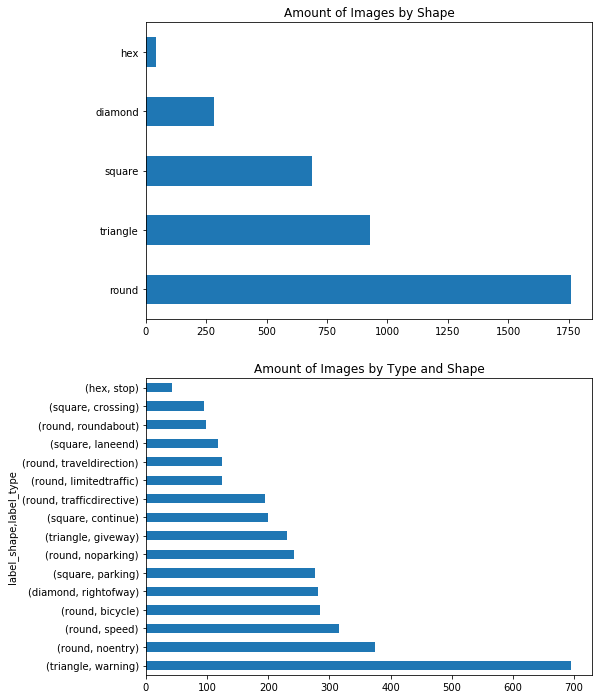

In [5]:
fig = plt.figure(figsize=(8,12))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Sort image count by shape
ax1.title.set_text('Amount of Images by Shape')

data['label_shape'].value_counts().plot(kind='barh', ax=ax1)

# Sort the images by Type[Shape]
ax2.title.set_text('Amount of Images by Type and Shape')

image_amount = data.groupby(['label_shape', 'label_type']).count().sort_values(by='image_path', ascending=False)
image_amount.plot(kind='barh', y='image_path', legend=False, ax=ax2)


plt.show()
fig.savefig('images/sign_occurences.png', dpi=300, bbox_inches='tight')

<a id='data_exp_ovr'></a>
## Overview

After exploring our images we notice that our highest source of shape is `round` that comes to around 1750, while `hex` has the least amount of representation at under **100.**

This will most likely cause issues in our model training, and we will need to access other possibilities for training, this is due to the poor representation of some of the shapes and types.

According to Warden accuracy of the training model would require around 1000 images of a single representation [1]. 
Looking to the data representation above we can see that `traingle` and `round` fit this recommendation, however going into the subsets of `types` we may have issues with relaiability for all but warning.

[Return to top](#top)

<a id="data_split"></a>
# Splitting into Training/Validation Sets

In order to split the data set, I chose to do it within notebook and not the file structure. I did not want to use sklearns `training_split` as I wanted to hold onto the **target labels** a little longer
>1. **Shuffle Dataframe** Utilise sklearn and shuffle the data set, then reset the index so the new data set is completely random
2. **Split Dataframe** Calculate an 80/20 split for the data set, then split the dataframe into 80% Training 20% Validation

## Shuffle Dataframe

In [6]:
# Rows before shuffle
data.loc[1100:1102,:]

,image_path,label_shape,label_type
1100,./trafficsigns_dataset/round/roundabout/01345_...,round,roundabout
1101,./trafficsigns_dataset/round/roundabout/01355_...,round,roundabout
1102,./trafficsigns_dataset/round/roundabout/00809_...,round,roundabout


In [4]:
# We need to shuffle in preparation for splitting the data set
from sklearn.utils import shuffle
data = shuffle(data)
data_german_traffic = shuffle(data_german_traffic)

# This will ensure the index is reset
data.reset_index(inplace=True, drop=True) 
data_german_traffic.reset_index(inplace=True, drop=True) 

In [8]:
# Selection of images after shuffle
data.loc[1100:1102,:]

,image_path,label_shape,label_type
1100,./trafficsigns_dataset/round/roundabout/01317_...,round,roundabout
1101,./trafficsigns_dataset/square/parking/01628_00...,square,parking
1102,./trafficsigns_dataset/square/parking/00451_00...,square,parking


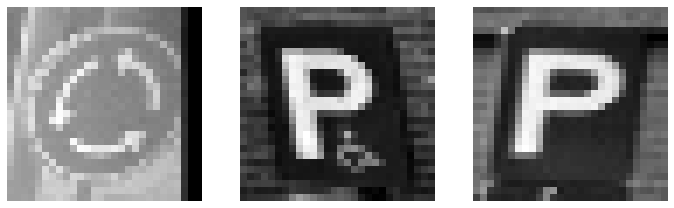

1100    ./trafficsigns_dataset/round/roundabout/01317_...
1101    ./trafficsigns_dataset/square/parking/01628_00...
1102    ./trafficsigns_dataset/square/parking/00451_00...
Name: image_path, dtype: object

In [9]:
# Graphical representation of images 
samp_data = data.loc[1100:1102,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(samp_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()
samp_data.head()

## Split Dataframe

In [10]:
# Calculate 0.70 of the dataframe, round for a clean figure
train_size = round(((data.shape[0]-1)*0.7))

train_data = data.loc[0:train_size,:]
aux_data = data.loc[train_size+1:,:]

train_data.reset_index(inplace=True, drop=True)
aux_data.reset_index(inplace=True, drop=True)

# Creating test data for end verification

val_size = round(((aux_data.shape[0]-1)*0.7))

val_data = aux_data.loc[0:val_size,:]
test_data_belgium = aux_data.loc[val_size+1:,:]

val_data.reset_index(inplace=True, drop=True)
test_data_belgium.reset_index(inplace=True, drop=True)

N_train_images = train_data.shape[0]
N_val_images = val_data.shape[0]

print(f"Original dataframe size: {data.shape[0]}")
print(f"New combined split size: {train_data.shape[0] + val_data.shape[0] + test_data_belgium.shape[0]}")

Original dataframe size: 3699
New combined split size: 3699


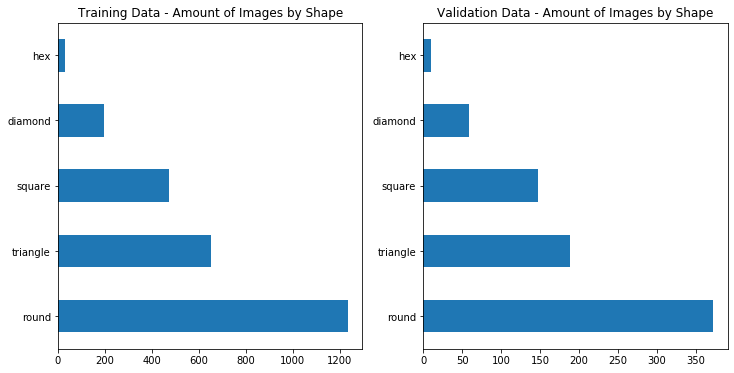

In [11]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# Sort image count by shape
ax1.title.set_text('Training Data - Amount of Images by Shape')

train_data['label_shape'].value_counts().plot(kind='barh', ax=ax1)

# Sort the images by Type[Shape]
ax2.title.set_text('Validation Data - Amount of Images by Shape')

val_data['label_shape'].value_counts().plot(kind='barh', ax=ax2)


plt.show()

fig.savefig('images/shape_occurences_post_split.png', dpi=300, bbox_inches='tight')

[Return to top](#top)

<a id="data_model"></a>
# Data Modeling


<a id="data_model_cnn"></a>
## Convolutional Neural Network (*Traffic Sign Shapes*)

<a id='data_model_cnn_simple'></a>
## Simple Image Model

For both the **simple model** and **augmented model** I kept the CCN simple. `Feature learning` consisted of 3 `convolutions + relu`. Utilising two instances of pooling, my intention was to reduce the computational size while trying to extract the dominant features. *This may however be over complication as the images do not represent overly complicated features in their 28x28 size.* 

The `classification` part utilised multiple drop outs, this was due to a previous experience of high overfitting.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam


def build_simple_model(n_classes):

    # Model Definition
    cnn = Sequential()

    cnn.add(Input(shape=(28, 28, 3)))
    cnn.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

    cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(0.2))

    cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(0.2))

    cnn.add(Flatten())

    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.5))

    cnn.add(Dense(units=n_classes, input_dim=1012, activation='softmax'))


    cnn.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    return cnn

## Highly Tuned CNN Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam



def build_model(n_classes, POOL_SIZE=(2, 2)):

    # Model Definition
    cnn = Sequential()

    cnn.add(Input(shape=(28, 28, 3)))
    cnn.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
    cnn.add(BatchNormalization())

    cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=POOL_SIZE))
    cnn.add(Dropout(0.2))

    cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    cnn.add(BatchNormalization())

    cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=POOL_SIZE))
    cnn.add(Dropout(0.2))

    cnn.add(Flatten())

    cnn.add(Dense(2048, activation='relu'))
    cnn.add(Dropout(0.5))

    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.5))

    cnn.add(Dense(units=n_classes, input_dim=2048, activation='softmax'))


    cnn.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    return cnn

## Plot Results

In [6]:
# plot the training loss and accuracy
def plot_results(history, num_epochs, plot_title, save=False):

    N = np.arange(0, num_epochs)
    plt.style.use("ggplot")

    plt.figure()

    plt.plot(N, history.history["loss"], label="train_loss")
    plt.plot(N, history.history["val_loss"], label="val_loss")
    plt.title(f"{plot_title} Training and Validation loss")
    plt.legend()
    plt.xlabel("Epoch no.")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    if save:
        plt.savefig(f"images/training_validation_loss_{plot_title}.png", dpi=200, bbox_inches='tight')

    plt.figure()

    plt.plot(N, history.history["accuracy"], label="train_acc")
    plt.plot(N, history.history["val_accuracy"], label="val_acc")
    plt.title(f"{plot_title} Training and Validation accuracy")
    plt.legend()
    plt.xlabel("Epoch no.")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper right")

    if save:
        plt.savefig(f"images/training_validation_accuracy_{plot_title}.png", dpi=200, bbox_inches='tight')

## Display Predictions

In [7]:
def display_predictions(model, image_generator):
    
    # Get the original classes
    labels = image_generator.class_indices

    d_inv = {v: k for k, v in labels.items()}
    plt.figure(figsize=(16,4))
    batches = 0
    i = 0
    for x,y in image_generator:
            batches = batches + 1
            y_hat = model.predict(x, verbose=0)
            x = np.squeeze(x)
            if batches < 5:
                plt.subplot(1,5,batches)
                plt.tight_layout()
                plt.imshow(x)
                plt.title("Tgt-{}, Pd-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))

            else:
                break

            plt.axis('off')

[Return to top](#top)

<a id='data_model_simple_generator'></a>
## Simple Image Generator

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 250
BS = 168
LEARNING_RATE = 0.0001

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=30, width_shift_range=0.2, 
                                   height_shift_range=0.2)

val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="label_shape",
        target_size=(28, 28),
        batch_size=BS,
        class_mode='categorical',
        color_mode='grayscale')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="label_shape",
        target_size=(28, 28),
        batch_size=BS,
        class_mode='categorical',
        color_mode='grayscale')

model_s = build_model(len(train_generator.class_indices))


# training the network
H = model_s.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    shuffle=True,
    validation_data=validation_generator,
    steps_per_epoch=train_data.shape[0] // BS,
    validation_steps=val_data.shape[0] // BS,
    verbose=0)

model_s.save_weights('cnn_simple.h5')

model_s.summary()

Found 2590 validated image filenames belonging to 5 classes.
Found 777 validated image filenames belonging to 5 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_

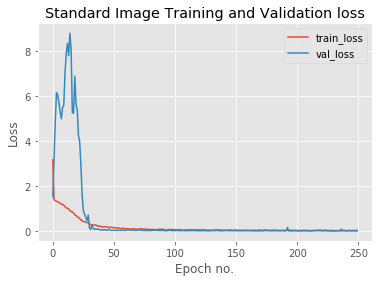

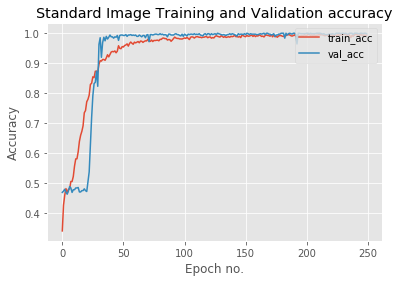

In [17]:
plot_results(H, NUM_EPOCHS, 'Standard Image', True)

[Return to top](#top)

<a id='data_model_cnn_aug'></a>
## Augmented Image Generator

Different variations of image augmentation was tried here, since some shapes bare similarities it was important to be quite broad with the image processing. 
- Such that in order to predict against other country signs that represent a triangle upside down in comparison to the Belgium style it was important to augment the image in vertical flip. 
- Rotation augmentation was emplaced for perspective issues and shifts were incorporated for moving images. 
- Another important augmentation was the brightness, since the given data set consisted of images that we overwhelmingly dark it was important to increase the generators brightness over batches.

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 250
BS = 168
LEARNING_RATE = 0.0001

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=30, width_shift_range=0.4, 
                                   height_shift_range=0.5, horizontal_flip=True,
                                   brightness_range=[0.5,2.0], vertical_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="label_shape",
        target_size=(28, 28),
        batch_size=BS,
        class_mode='categorical',
        color_mode='grayscale')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="label_shape",
        target_size=(28, 28),
        batch_size=BS,
        class_mode='categorical',
        color_mode='grayscale')

Found 2590 validated image filenames belonging to 5 classes.
Found 777 validated image filenames belonging to 5 classes.


<a id='data_model_aug_examples'></a>
### Augemented Pictures Examples

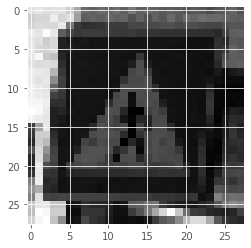

In [19]:
import cv2

img = data.loc[1333:1333, 'image_path'].values[0]
x = cv2.imread(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='sign_augmented', save_format='jpeg'):
    i += 1
    if i > 20:
        break 
        
image = Image.open(img)
plt.imshow(image, cmap='gray')

### Build Model with Augmented Image Generator

In [20]:
model_a = build_model(len(train_generator.class_indices))

# training the network
H = model_a.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    shuffle=True,
    validation_data=validation_generator,
    steps_per_epoch=train_data.shape[0] / BS,
    validation_steps=val_data.shape[0] / BS,
    verbose=0)

model_a.save_weights('cnn_augmented.h5')

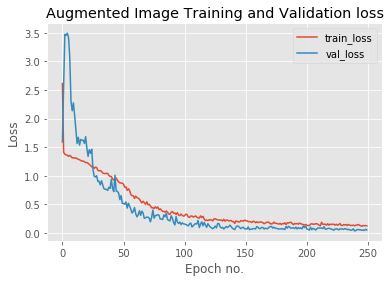

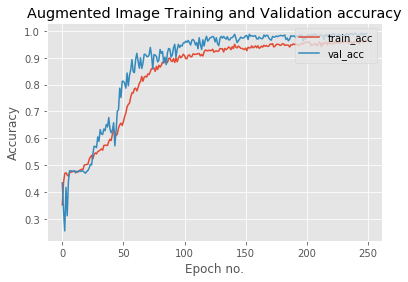

In [21]:
plot_results(H, NUM_EPOCHS, 'Augmented Image', True)

[Return to top](#top)

<a id='data_model_aug_pred'></a>
## Predictions with Augmented Image CNN Model

Found 315 validated image filenames belonging to 5 classes.


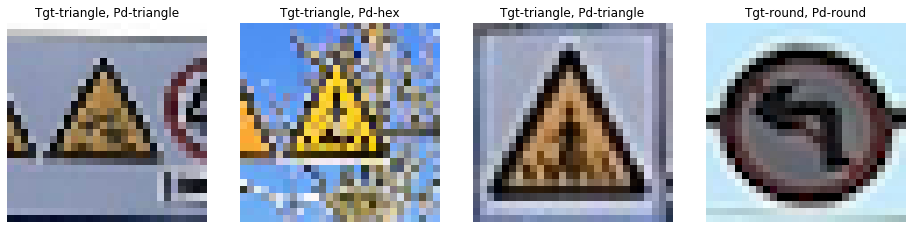

In [33]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import load_model
from skimage import transform, color, io, exposure
from imutils import paths
import numpy as np
import argparse
import imutils
import random
import cv2
import os


#Import images from file structure
image_list = []
for filepath in glob.glob('./root/test/*/*.png', recursive=True):
    filename = filepath.split("/")[-1]
    label_shape = filepath.split("/")[3]
    image_list.append((filepath, label_shape))

# create the dataframe
test_data_individual = pd.DataFrame(data=image_list, columns=['image_path', 'label_shape'])

pred_model = build_model(5)
pred_model.load_weights('cnn_augmented.h5')

batch_size_t = 1

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_individual,
        directory='./',
        x_col="image_path",
        y_col="label_shape",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical',
        shuffle=True,
        classes= ['diamond','hex', 'round', 'square', 'triangle'])

display_predictions(pred_model, test_generator)

[Return to top](#top)

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = pred_model.predict(test_generator, test_data_individual.shape[0] // BS+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['diamond','hex', 'round', 'square', 'triangle']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[  0   0   0   0   2]
 [  0   0   2   0   0]
 [  0   4 156   7  14]
 [  0   0   7   3   8]
 [  0  31   8  10  63]]
Classification Report
              precision    recall  f1-score   support

     diamond       0.00      0.00      0.00         2
         hex       0.00      0.00      0.00         2
       round       0.90      0.86      0.88       181
      square       0.15      0.17      0.16        18
    triangle       0.72      0.56      0.63       112

    accuracy                           0.70       315
   macro avg       0.36      0.32      0.33       315
weighted avg       0.78      0.70      0.74       315



<a id='data_model_cnn_sign_type'></a>
## Convolutional Neural Network: *Traffic Sign Types*

Augmenting the image generator needed to be more specific and gentle, unlike `Traffic Sign Shapes`, `Types` have more specific detail captured inside the location. 
- Because of the attention to the detail within the sign, augmentations like `vertical_flip` would be more detrimental than helpful.
- `horizontal_flip` was necessary as signs that point left may also point right and be considered a similar `Type`
- Additionally I focused on gentle movements with range shift, and toned down the parameters for brightness as to not drown out the inside information

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 350
BS = 168
LEARNING_RATE = 0.0001

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=20, width_shift_range=0.4, 
                                   height_shift_range=0.1, horizontal_flip=True,
                                   brightness_range=[0.7,1.5], vertical_flip=False)

val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')


train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="image_path",
        y_col="label_type",
        target_size=(28, 28),
        batch_size=BS,
        class_mode='categorical',
        color_mode='grayscale')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="image_path",
        y_col="label_type",
        target_size=(28, 28),
        batch_size=BS,
        class_mode='categorical',
        color_mode='grayscale')

Found 2590 validated image filenames belonging to 16 classes.
Found 777 validated image filenames belonging to 16 classes.


### Spread of data over all splits

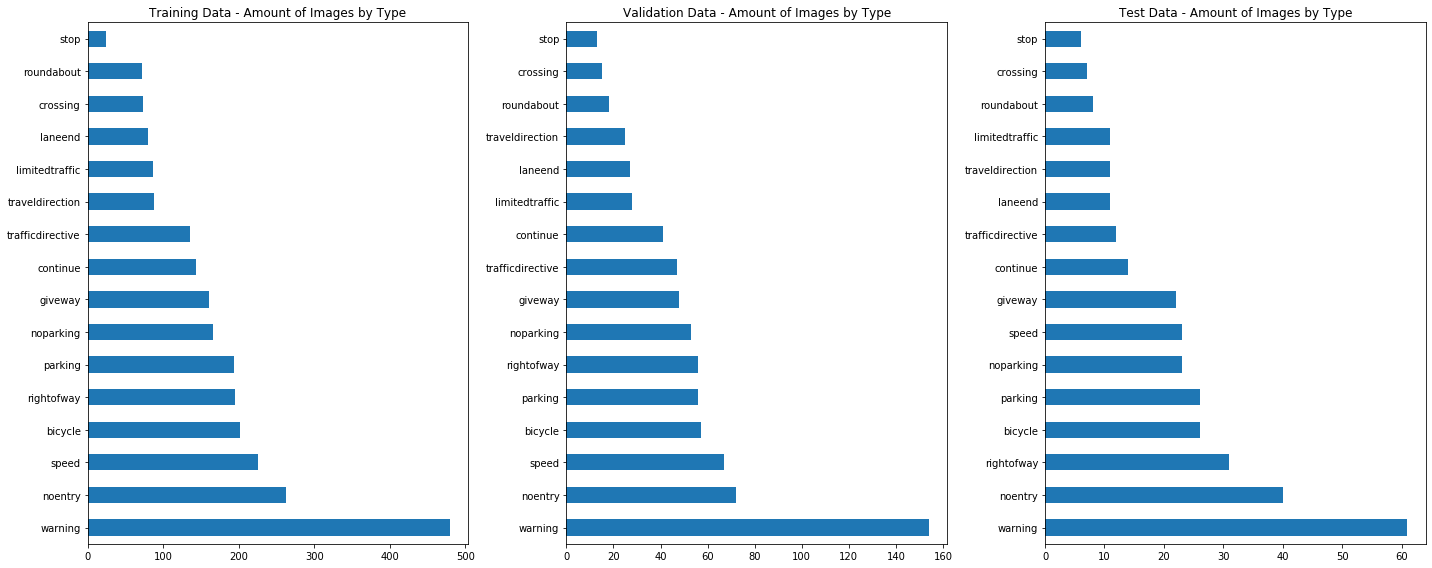

In [35]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.title.set_text('Training Data - Amount of Images by Type')
train_data['label_type'].value_counts().plot(kind='barh', ax=ax1)

ax2.title.set_text('Validation Data - Amount of Images by Type')
val_data['label_type'].value_counts().plot(kind='barh', ax=ax2)

ax3.title.set_text('Test Data - Amount of Images by Type')
test_data_belgium['label_type'].value_counts().plot(kind='barh', ax=ax3)

plt.tight_layout()
plt.show()

fig.savefig('images/type_occurences_post_split.png', dpi=300, bbox_inches='tight')

### Saved examples of augmented batches

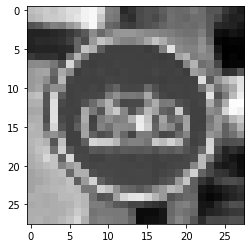

In [36]:
from PIL import Image
import cv2

img = data.loc[777:777, 'image_path'].values[0]
x = cv2.imread(img)
x = x.reshape((1,) + x.shape)


i = 0
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='preview_type', save_prefix='sign_augmented', save_format='jpeg'):
    i += 1
    if i > 20:
        break 
        

image = Image.open(img)
plt.imshow(image, cmap='gray')

[Return to top](#top)

### Build Traffic Sign Type Model

In [37]:
model_t = build_model(len(train_generator.class_indices))

# training the network
H = model_t.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    shuffle=True,
    validation_data=validation_generator,
    steps_per_epoch=train_data.shape[0] / BS,
    validation_steps=val_data.shape[0] / BS,
    verbose=0)

model_t.save_weights('cnn_type.h5')

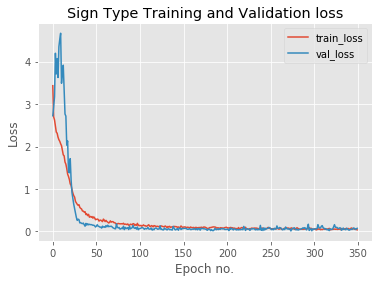

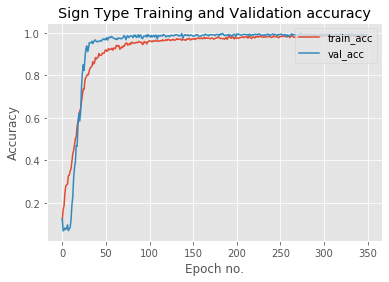

In [38]:
plot_results(H, NUM_EPOCHS, 'Sign Type', save=True)

[Return to top](#top)

<a id='data_model_aug_pred_sign_type'></a>
## Type Predictions with Augmented Image CNN Model

Found 332 validated image filenames belonging to 16 classes.


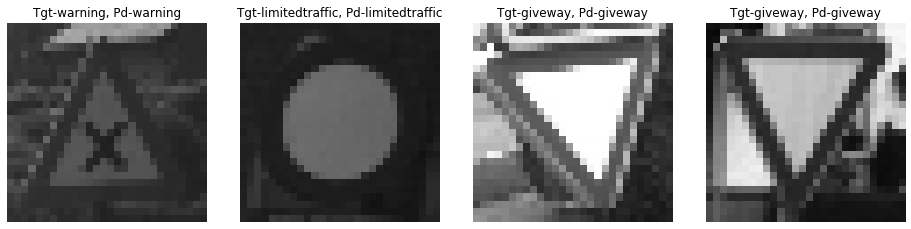

In [13]:
# Necessary to bring in class labels, as some data is extremely scarce
classes = ['parking', 'speed', 'limitedtraffic', 'continue', 'crossing', 
             'laneend', 'trafficdirective', 'noparking', 'bicycle', 'roundabout', 
             'noentry', 'giveway', 'warning', 'traveldirection', 'rightofway', 'stop']

pred_model = build_model(len(train_generator.class_indices))
pred_model.load_weights('cnn_type.h5')

batch_size_t = 1

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_belgium,
        directory='./',
        x_col="image_path",
        y_col="label_type",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical',
        classes=classes)

display_predictions(pred_model, test_generator)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = pred_model.predict(test_generator, test_data_belgium.shape[0] // BS+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['bicycle','continue', 'crossing','giveway','laneend','limitedtraffic','noentry', 
                'noparking','parking','rightofway','roundabout', 'speed','stop','trafficdirective',
                'traveldirection', 'warning']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 4  1  0  2  1  1  3  1  1  2  1  4  1  3  1  3]
 [ 3  1  0  0  1  1  1  1  3  1  0  2  0  3  1  2]
 [ 0  0  0  0  0  0  1  1  0  1  0  0  0  1  0  3]
 [ 2  0  0  0  0  2  2  2  0  1  0  0  0  1  0  4]
 [ 1  3  0  1  0  0  0  0  0  1  0  1  0  1  0  3]
 [ 1  0  1  1  0  1  0  0  0  1  0  0  0  0  2  3]
 [ 2  3  1  2  0  2  3  3  3  6  1  4  0  1  2  7]
 [ 2  2  0  1  0  0  3  3  1  1  1  3  0  2  1  5]
 [ 3  1  1  1  0  0  1  2  1  1  1  2  1  2  0  2]
 [ 2  3  0  1  0  1  5  0  1  3  0  2  0  1  1  5]
 [ 1  1  0  0  1  0  0  0  2  0  1  0  0  0  0  2]
 [ 1  2  2  1  0  1  3  1  1  3  1  3  0  0  2  8]
 [ 0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  1]
 [ 2  0  0  2  1  0  5  1  0  2  0  2  0  0  0  2]
 [ 1  2  0  0  0  0  3  0  0  1  0  1  0  1  2  2]
 [ 5  1  2  2  7  2  8 10  6  0  2  4  1  1  1 10]]
Classification Report
                  precision    recall  f1-score   support

         bicycle       0.13      0.14      0.14        29
        continue       0.05

## Type Predictions on Individual Dataset

Found 312 validated image filenames belonging to 16 classes.


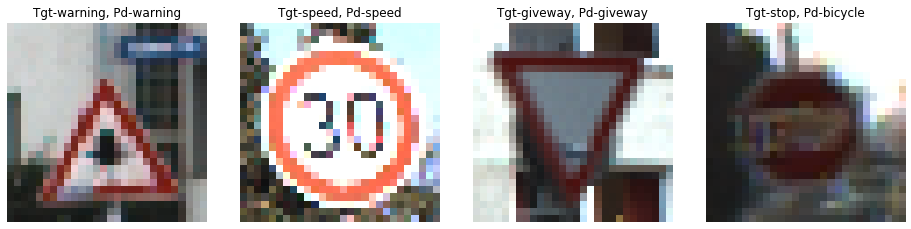

In [16]:
pred_model = build_model(len(train_generator.class_indices))
pred_model.load_weights('cnn_type.h5')

batch_size_t = 1

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=data_german_traffic,
        directory='./',
        x_col="image_path",
        y_col="label_type",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical',
        classes=['parking', 'speed', 'limitedtraffic', 'continue', 'crossing', 
             'laneend', 'trafficdirective', 'noparking', 'bicycle', 'roundabout', 
             'noentry', 'giveway', 'warning', 'traveldirection', 'rightofway', 'stop'],
        shuffle=True)

display_predictions(pred_model, test_generator)

[Return to top](#top)

<a id="proj_rev"></a>
# Project Review

Please refer to attached report

<a id='ref'></a>
## References

[1] Pete Warden, How many images do you need to train a neural network? (Dec 14, 2017). Accessed May 24, 2020. [Blog]. Available: https://petewarden.com/2017/12/14/how-many-images-do-you-need-to-train-a-neural-network/

[Return to top](#top)